# NST with Pytorch

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# for google colab
# copy all files from "ML/Neural_Style_Transfer" directory in Google drive to current directory
!cp -r ./gdrive/MyDrive/ML/Neural_Style_Transfer/* .

In [3]:
# This detect if cuda is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
print(imsize)

cuda
512


In [4]:
# Helper function
def image_loader(image_name):
    # scale imported image
    # transform it into a torch tensor
    loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Helper function to show the tensor as a PIL image
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [5]:
# Loading images
image_directory = "images/"
# style_img = image_loader(image_directory + "picasso.jpg")
# content_img = image_loader(image_directory + "dancing.jpg")
style_img = image_loader(image_directory + "image_part_002.jpg")
content_img = image_loader(image_directory + "image_part_001.jpg")

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

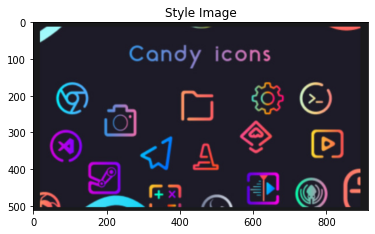

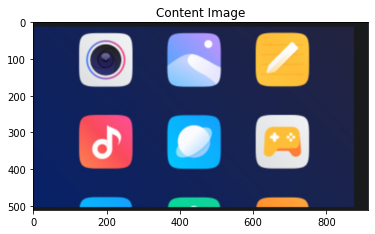

In [6]:
plt.ion()
# Show style image
plt.figure()
imshow(style_img, title='Style Image')
# Show content image
plt.figure()
imshow(content_img, title='Content Image')

In [7]:
# Importing the VGG 19 model like in the paper (here we set it to evaluation mode)
# cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn = models.vgg16(pretrained=True).features.to(device).eval()
# cnn = models.vgg13(pretrained=True).features.to(device).eval()
# cnn = models.vgg19_bn(pretrained=True).features.to(device).eval()
# cnn = models.vgg16_bn(pretrained=True).features.to(device).eval()
# cnn = models.vgg13_bn(pretrained=True).features.to(device).eval()

# VGG network are normalized with special values for the mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
# Hyperparameters
num_steps = 1500
default_num_steps = 300
default_style_weight = 1000000
default_content_weight = 1

In [9]:
# Custom content loss
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [10]:
# This is for the style loss
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

# Same structure as the content loss
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [11]:
# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [12]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

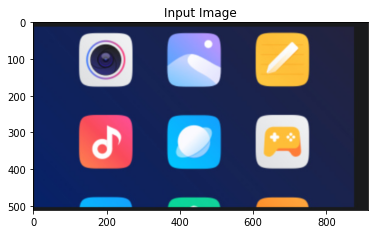

In [13]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

# This type of optimizer was prefered by the author of the paper
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [14]:
# This will run the neural style transfer
# It will create image that goes above 1 or below 0, however it will be normalized
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=default_num_steps,
                       style_weight=default_style_weight, content_weight=default_content_weight):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction to have the tensors between 0 and 1
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Optimizing..
run [50]:
Style Loss : 137.149536 Content Loss: 9.433175

run [100]:
Style Loss : 51.711262 Content Loss: 10.169388

run [150]:
Style Loss : 25.505632 Content Loss: 10.668444

run [200]:
Style Loss : 16.109289 Content Loss: 10.725191

run [250]:
Style Loss : 12.109385 Content Loss: 10.467344

run [300]:
Style Loss : 9.611356 Content Loss: 10.273170

run [350]:
Style Loss : 7.770651 Content Loss: 10.136653

run [400]:
Style Loss : 6.405505 Content Loss: 10.035084

run [450]:
Style Loss : 5.357206 Content Loss: 9.944110

run [500]:
Style Loss : 4.535504 Content Loss: 9.857768

run [550]:
Style Loss : 3.863744 Content Loss: 9.752361

run [600]:
Style Loss : 3.226579 Content Loss: 9.640304

run [650]:
Style Loss : 2.777540 Content Loss: 9.541577

run [700]:
Style Loss : 2.348517 Content Loss: 9.435815

run [750]:
Style Loss : 2.058670 Content Loss: 9.351305

run [800]:
Style Loss : 1.790063 Content Loss: 9.288680

run [850]:
Style Loss : 1.579013 Content Loss: 9.234593

run [9

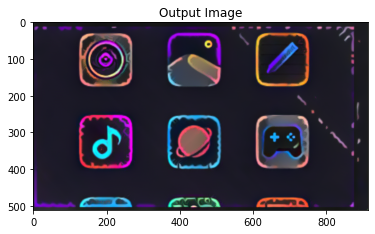

In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()